In [8]:
from collections import OrderedDict
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn
import theano as thno
import theano.tensor as T
import matplotlib.lines as mlines
from scipy import integrate
from scipy.optimize import fmin_powell

In [9]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

In [10]:
def run_models(df, upper_order=5):
    """
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    """

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1, upper_order + 1):

        nm = f"k{k}"
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print(f"\nRunning: {nm}")
            pm.glm.GLM.from_formula(fml, df, family=pm.glm.families.Binomial())

            traces[nm] = pm.sample(1000, tune=1000, init="adapt_diag", return_inferencedata=True)

    return models, traces


def plot_traces(traces, model, retain=0):
    """
    Convenience function:
    Plot traces with overlaid means and values
    """
    with model:
        ax = pm.traceplot(
            traces[-retain:],
            lines=tuple([(k, {}, v["mean"]) for k, v in pm.summary(traces[-retain:]).iterrows()]),
        )

        for i, mn in enumerate(pm.summary(traces[-retain:])["mean"]):
            ax[i, 0].annotate(
                f"{mn:.2f}",
                xy=(mn, 0),
                xycoords="data",
                xytext=(5, 10),
                textcoords="offset points",
                rotation=90,
                va="bottom",
                fontsize="large",
                color="#AA0022",
            )


def create_poly_modelspec(k=1):
    """
    Convenience function:
    Create a polynomial modelspec string for patsy
    """
    return (
        'Group ~ S100 + NSEV + GFAP + NFL + Tau' + " ".join([f"+ np.power(age,{j})" for j in range(2, k + 1)])
    ).strip()

In [11]:
import os
os.chdir("/Users/Sarah/Desktop")
df = pd.read_csv("blood_markers.csv")

In [12]:
df.dropna(inplace=True)
df = df[~df['Group'].isin(['analysis error/unclassifiable', 'insuff follow-up'])]
df['Group'].replace('PSE', 'epilepsy', inplace=True)
group = 1 * (df["Group"] == "epilepsy")
df = df[['S100', 'NSEV', 'GFAP', 'NFL', 'Tau']] 
df['Group'] = group

In [13]:
#Informative priors
with pm.Model() as mdl_ols_glm:
    # Define priors for intercept and regression coefficients.
    priors = {
        "Intercept": pm.Normal.dist(mu=42, sigma=10),
        "S100": pm.Normal.dist(mu=0.08, sigma=0.06),
        "NSEV": pm.Normal.dist(mu=9.28, sigma=3.86),
        "GFAP": pm.Normal.dist(mu=195, sigma=123),
        "NFL": pm.Normal.dist(mu=16, sigma=12.9),
        "Tau": pm.Normal.dist(mu=2.6, sigma=2.3)}
    # setup model with Normal likelihood (which uses HalfCauchy for error prior)
    pm.glm.GLM.from_formula('Group ~ S100 + NSEV + GFAP + NFL + Tau', df, family=pm.glm.families.Normal())

    traces_ols_glm = pm.sample(2000)

<ipython-input-13-8c594b57b139>:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces_ols_glm = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, Tau, NFL, GFAP, NSEV, S100, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 54 seconds.


<ipython-input-10-601e85e22ceb>:31: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  ax = pm.traceplot(


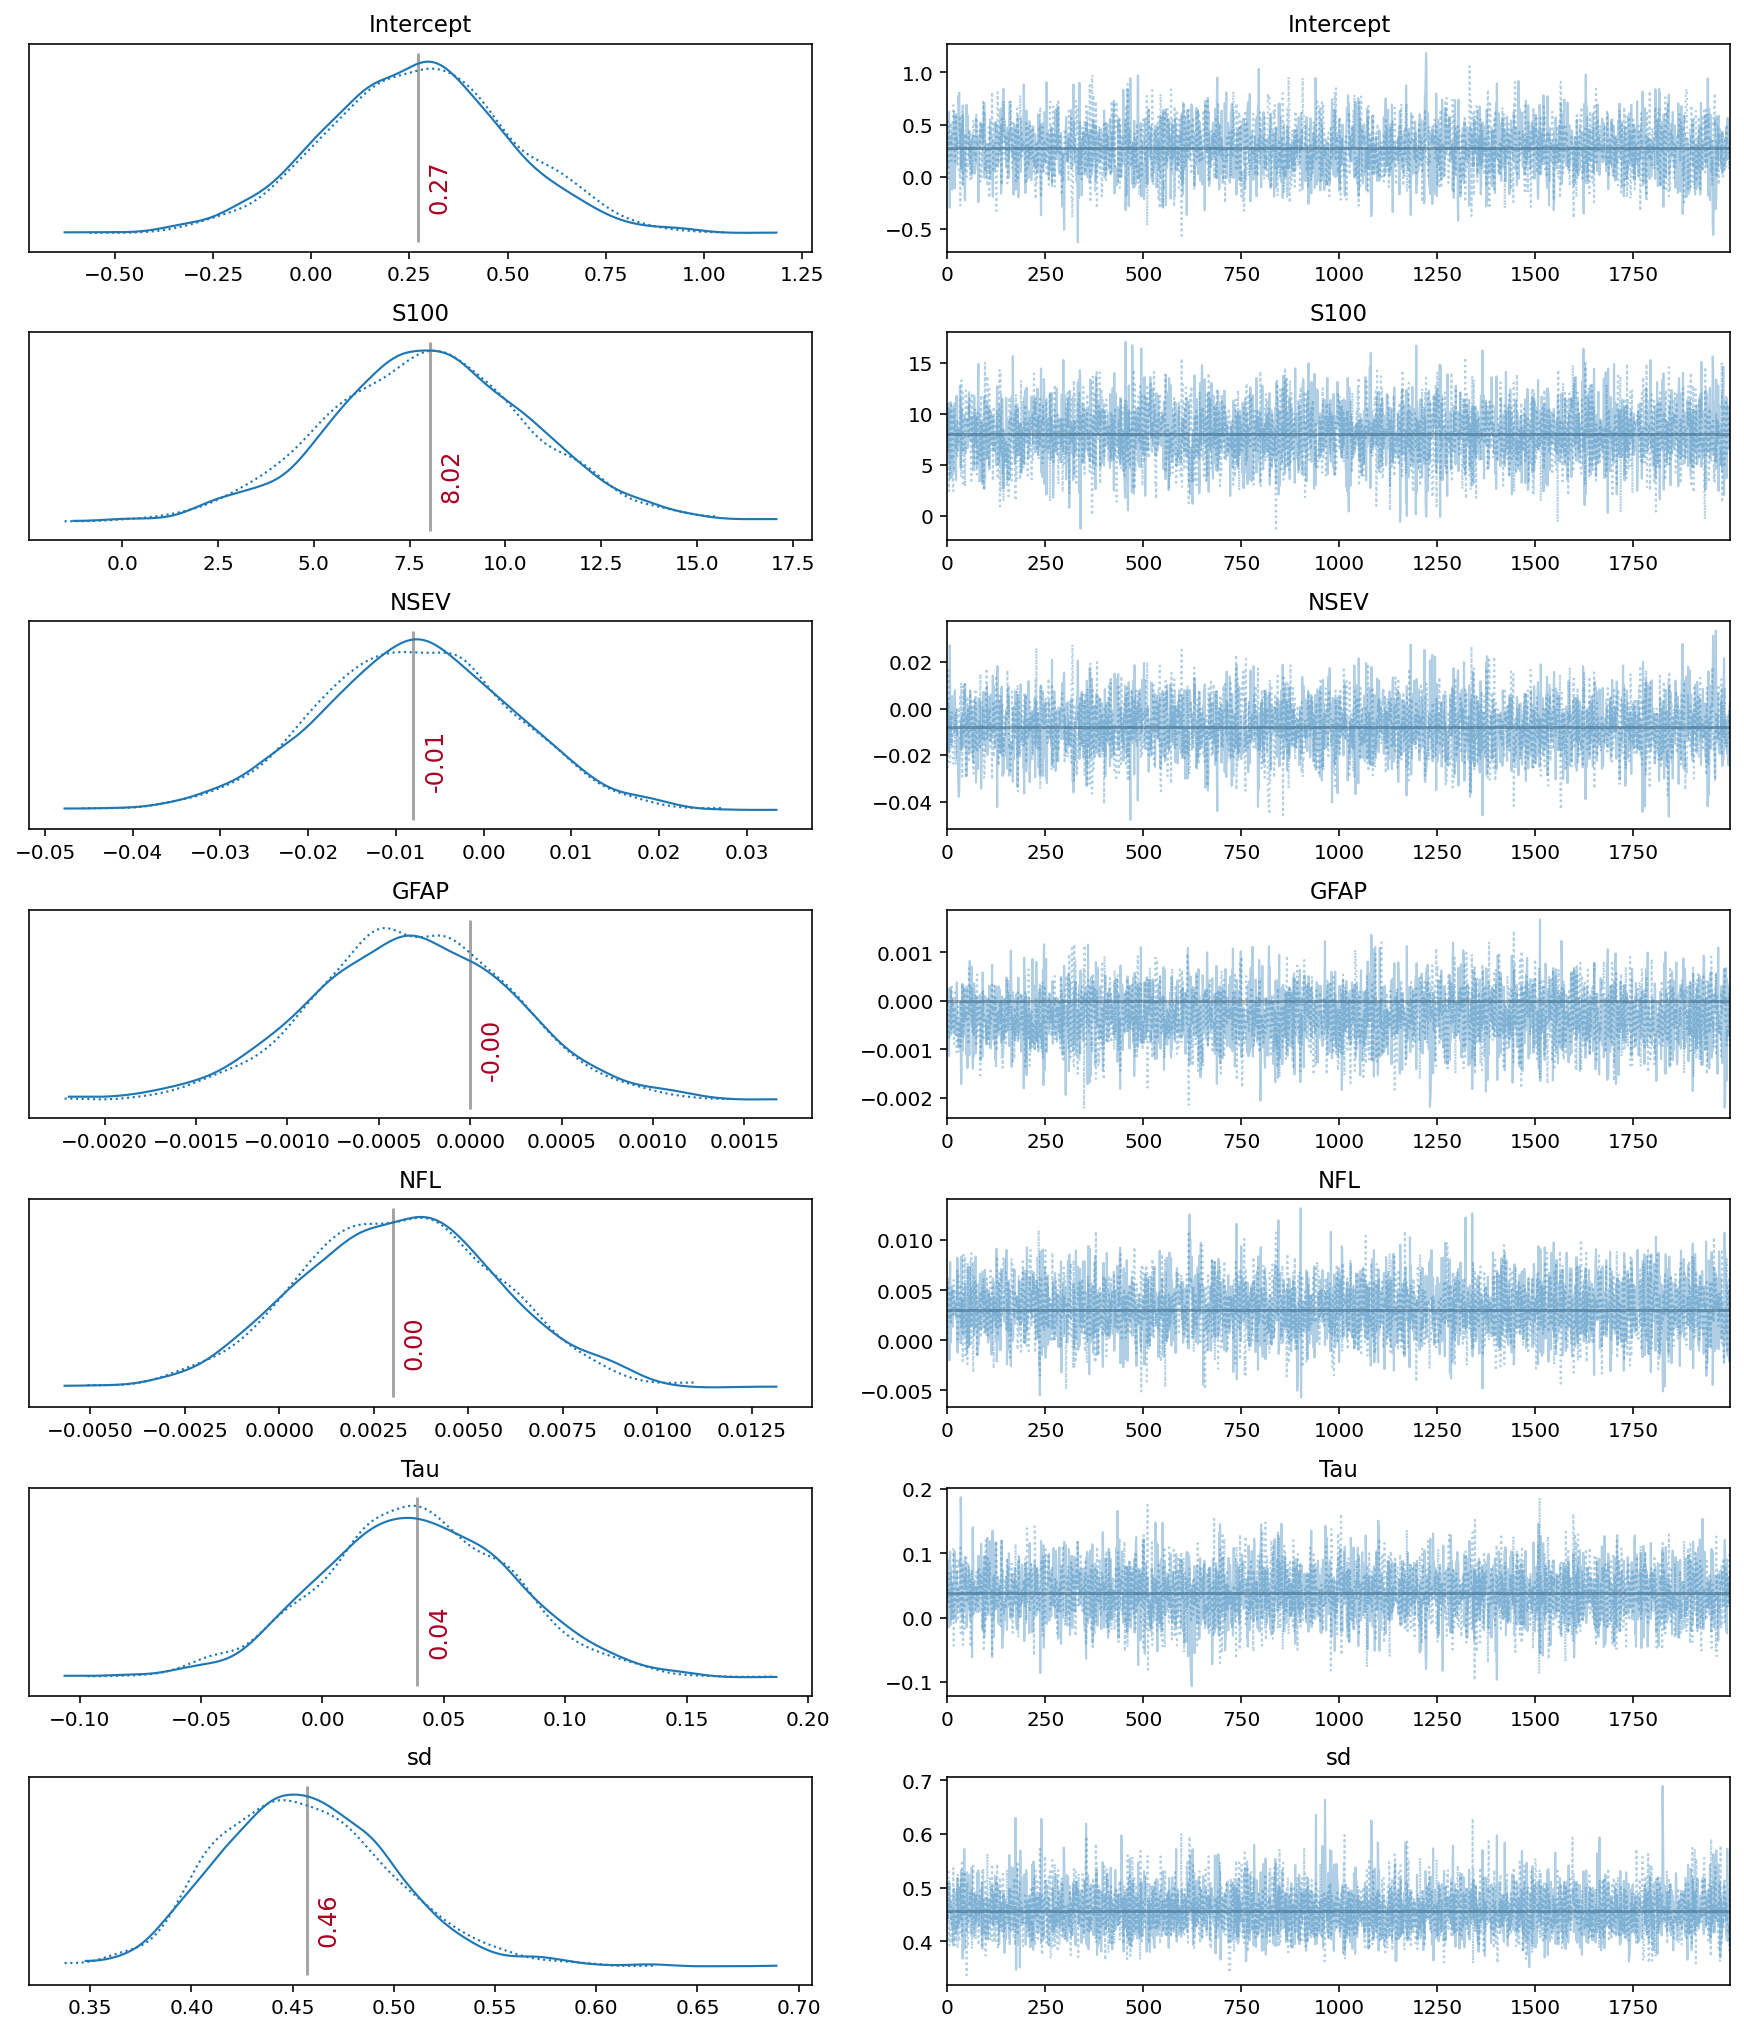

In [14]:
plot_traces(traces_ols_glm, mdl_ols_glm);

In [15]:
from sklearn.metrics import classification_report
ppc = pm.sample_posterior_predictive(traces_ols_glm, model=mdl_ols_glm, samples=500)
preds = np.rint(ppc['y'].mean(axis=0)).astype('int')
print(classification_report(df['Group'], preds))

/Users/Sarah/.local/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


              precision    recall  f1-score   support

           0       0.69      0.41      0.51        22
           1       0.73      0.90      0.80        39

    accuracy                           0.72        61
   macro avg       0.71      0.65      0.66        61
weighted avg       0.72      0.72      0.70        61



In [17]:
#Uninformative priors
with pm.Model() as mdl_ols_glm2:
    # Define priors for intercept and regression coefficients.
    priors = {
        "Intercept": pm.Normal.dist(mu=0, sigma=10),
        "S100": pm.Normal.dist(mu=0, sigma=10),
        "NSEV": pm.Normal.dist(mu=0, sigma=10),
        "GFAP": pm.Normal.dist(mu=0, sigma=10),
        "NFL": pm.Normal.dist(mu=0, sigma=10),
        "Tau": pm.Normal.dist(mu=0, sigma=10)}
    # setup model with Normal likelihood (which uses HalfCauchy for error prior)
    pm.glm.GLM.from_formula('Group ~ S100 + NSEV + GFAP + NFL + Tau', df, family=pm.glm.families.Normal())

    traces_ols_glm2 = pm.sample(2000)

<ipython-input-17-62139e81715c>:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces_ols_glm2 = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, Tau, NFL, GFAP, NSEV, S100, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 54 seconds.


<ipython-input-10-601e85e22ceb>:31: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  ax = pm.traceplot(


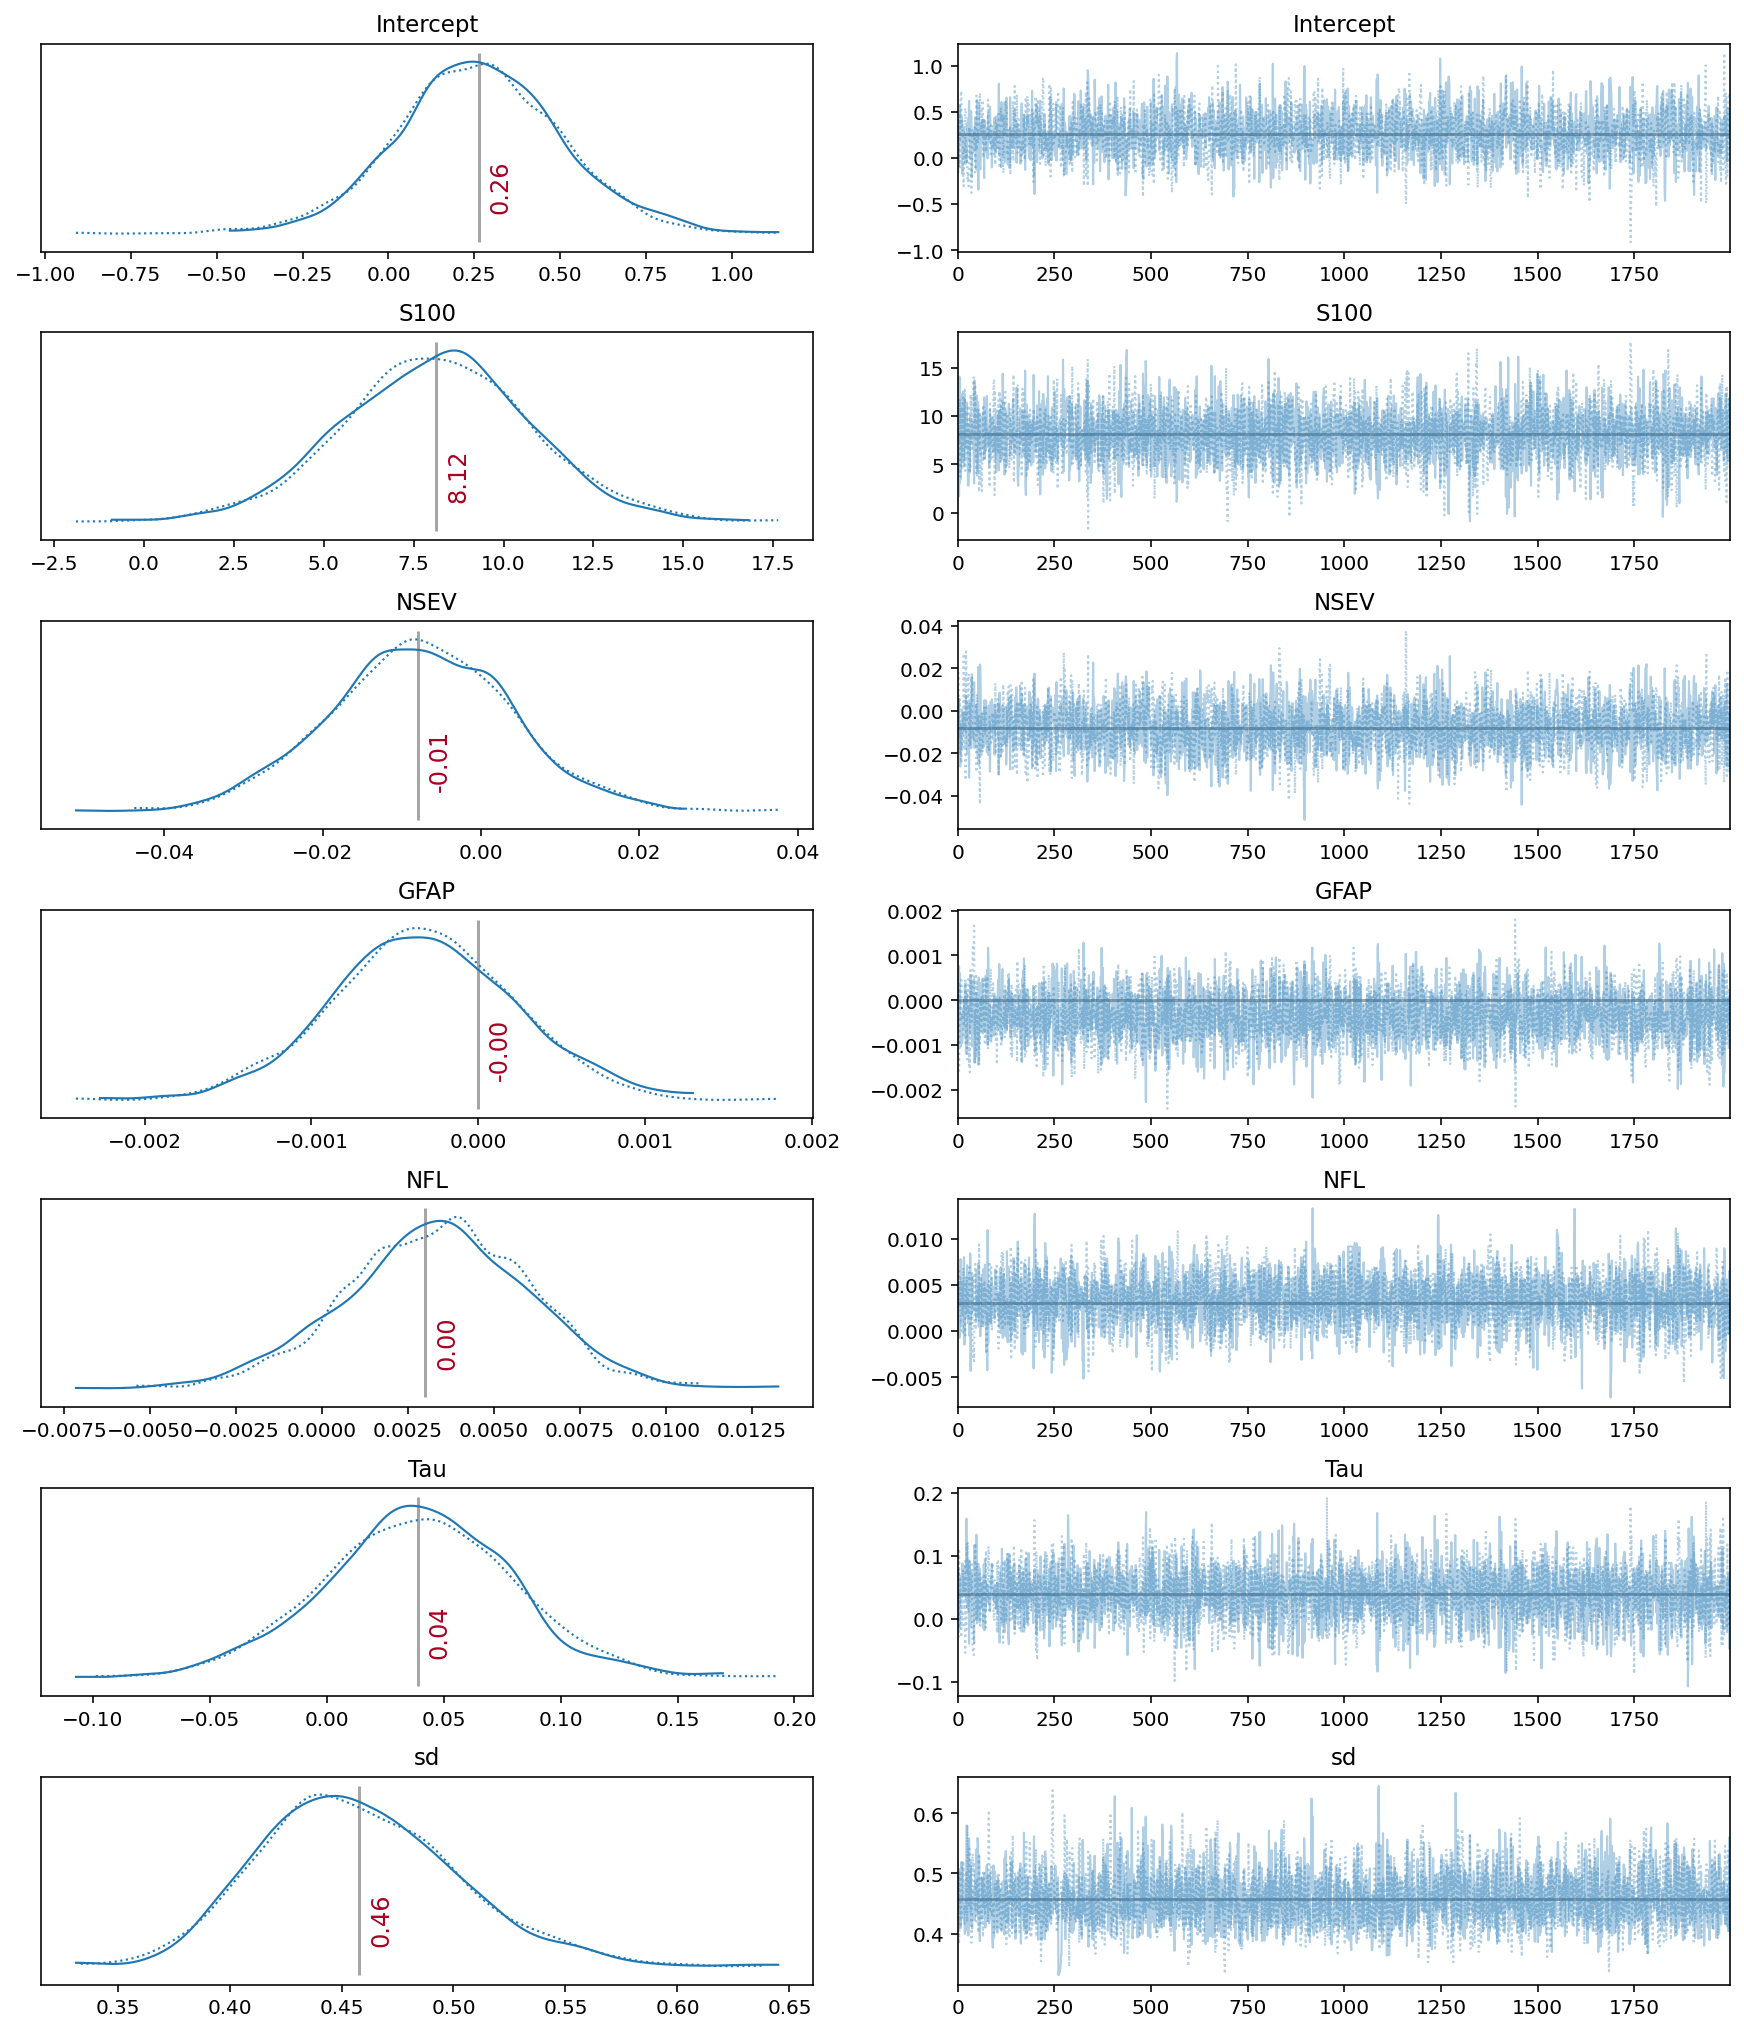

In [18]:
plot_traces(traces_ols_glm2, mdl_ols_glm2);

In [19]:
from sklearn.metrics import classification_report
ppc = pm.sample_posterior_predictive(traces_ols_glm2, model=mdl_ols_glm2, samples=500)
preds = np.rint(ppc['y'].mean(axis=0)).astype('int')
print(classification_report(df['Group'], preds))

/Users/Sarah/.local/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


              precision    recall  f1-score   support

           0       0.71      0.45      0.56        22
           1       0.74      0.90      0.81        39

    accuracy                           0.74        61
   macro avg       0.73      0.68      0.68        61
weighted avg       0.73      0.74      0.72        61

